# Rebust Url Malware Detection
some explanning

In [1]:
import numpy as np
import seaborn as sns 
import pandas as pd 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
# ------------- Preprocess
from ast import literal_eval # Transform/Parse a string-list into a proper list.
import swifter
import urllib
import re
import math
from pyquery import PyQuery
import requests
import socket
import json
from shodan import Shodan
from whois import whois
from waybackpy import Cdx
from datetime import datetime
import time
import string

In [2]:
df = pd.read_csv("Data/malicious_phish.csv")
df

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement
...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing
651188,www.gamespot.com/xbox360/action/deadspace/,phishing
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing


<AxesSubplot:xlabel='type', ylabel='count'>

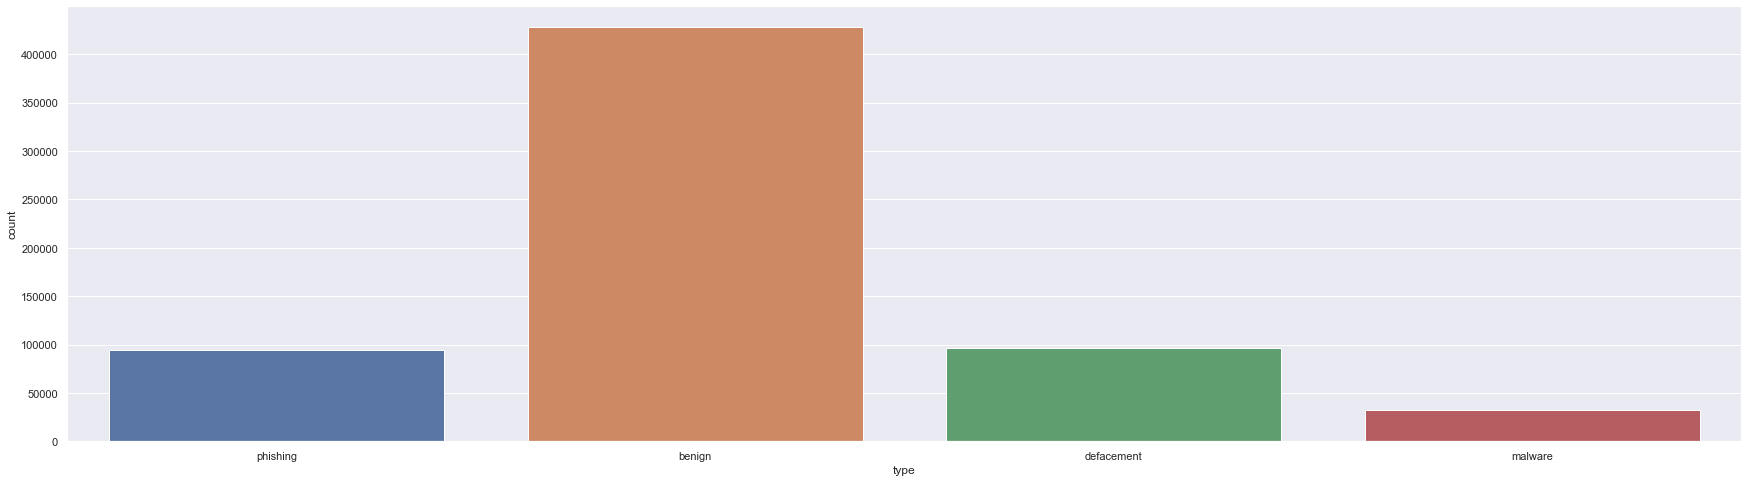

In [3]:
sns.set(rc={'figure.figsize':(30,8)})
sns.countplot(data=df, x='type')

<BarContainer object of 2 artists>

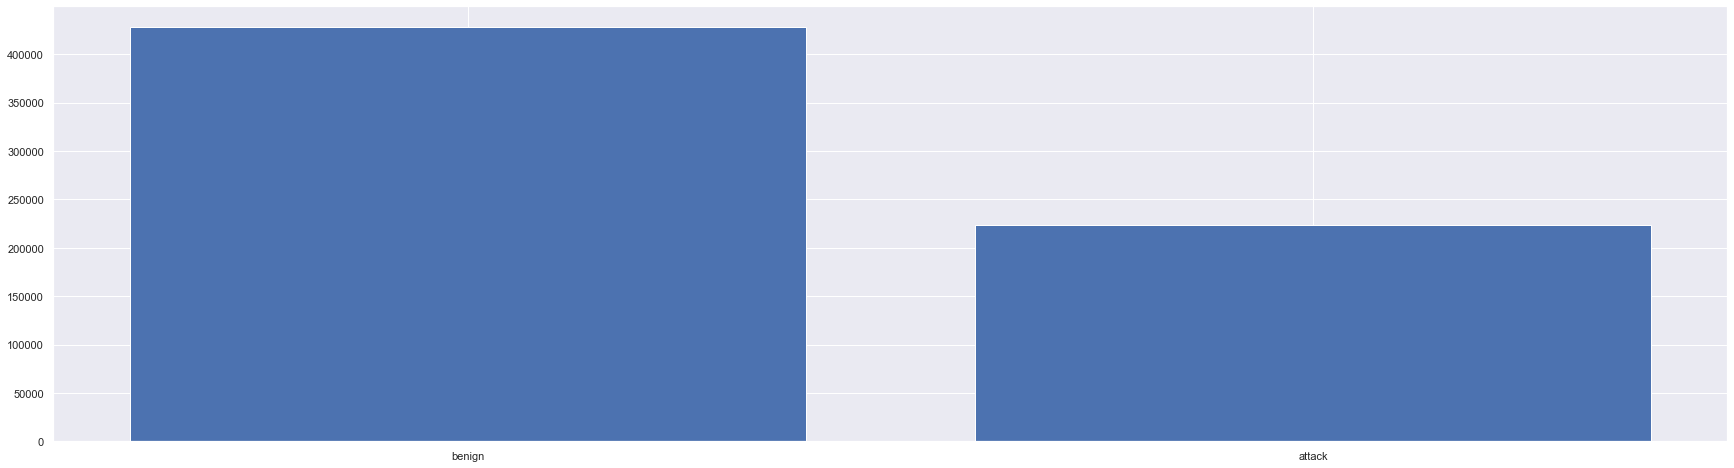

In [4]:
plt.bar(["benign","attack"],[(df['type']=='benign').sum(),(df['type']!='benign').sum()])

In [7]:
df = df.sample(50000)

## Preproccess

### Lexical Features: 
These refer to statistical features extracted from the literal URL string. For example, length of the URL string, number of digits, number of parameters in its query part, if the URL is encoded, etc.
see https://towardsdatascience.com/extracting-feature-vectors-from-url-strings-for-malicious-url-detection-cbafc24737a

### Content-Based Features
These are obtained from the downloaded HTML code of the webpage. These features capture the structure of the webpage and the content embedded in it. These will include information on script tags, embedded objects, executables, hidden elements, etc.

### Host-Based Features
these are characteristics of the host-name properties of the URL. These provide information about the host of the webpage, for example, country of registration, domain name properties, open ports, named servers, connection speed, time to live from registration, etc.

In [1]:
from Helpers.preprocess.main import preprocess
df = preprocess()

In [43]:
# list(df.select_dtypes('O').columns)
# df[df.isna().any(axis=1)].head()
#df = df.dropna(axis='index')

['url', 'url_schema', 'tld']

## Models

In [ ]:
import xgboost as xgb

In [45]:
X,y = df.drop(['url','type'],axis=1),df['type']

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,  random_state=42)
print(X_train.shape, y_train.shape,X_test.shape, y_test.shape)

(520942, 697) (520942,) (130236, 697) (130236,)


In [47]:
pca = PCA(n_components=0.99)
pca_X = pca.fit_transform(X_train)
pca_X

array([[ 6.70167183e+01,  3.67776614e+01, -5.05706902e-01,
        -6.61482016e+00],
       [ 3.74989690e+01, -3.68015359e+01,  1.26018485e+01,
        -6.46022734e+00],
       [ 3.67608275e+01,  2.86697221e+01,  2.49955705e+00,
         1.67870778e+01],
       ...,
       [ 2.21767801e+01, -3.04619153e+01,  7.90817600e+00,
         2.54818436e-02],
       [-1.74187806e+00,  8.00428724e+00, -2.17627514e+00,
         1.97904881e+00],
       [-1.37123702e+01,  1.40283523e+01,  6.91918836e+00,
        -8.16925047e-01]])

In [50]:
y_train.value_counts()

0    342425
1     77241
3     75226
2     26050
Name: type, dtype: int64

In [48]:
pca_X.shape

(520942, 4)

In [ ]:
def xgboost_pipeline(x_train, y_train, x_test,num_round=1000,thr=0.5):
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1,random_state=1)
    param = {"learning_rate": 0.05, "max_depth": 8, "min_child_weight": 1, "gamma": 0, "subsample": 0.7,
             "objective": 'multi:softmax','num_class':len(np.unique(y_train.values)), "scale_pos_weight": 1, "seed": 93, "eval_metric": "mlogloss"}
    d_train = xgb.DMatrix(pca_X, label=y_train)
    d_eval = xgb.DMatrix(x_val, label=y_val)
    evallist = [(d_eval, 'eval'), (d_train, 'train')]
    bst = xgb.train(param, d_train, num_round, evallist)
    d_test = xgb.DMatrix(x_test)
    xgboost_pred = bst.predict(d_test)
    xgboost_pred[xgboost_pred > thr] = 1
    xgboost_pred[xgboost_pred <= thr] = 0
    return xgboost_pred,bst

In [ ]:
xgboost_pred,bst_binary = xgboost_pipeline(X_train,y_train,X_test)
print(classification_report(y_test, xgboost_pred))

In [ ]:
clf = RandomForestClassifier(max_depth=8, random_state=0,)
clf.fit(X_train, y_train)
clf_prediction = clf.predict(X_test)
print(classification_report(y_test, clf_prediction))

In [ ]:
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train)
pred = neigh.predict(X_test)
print(classification_report(y_test,pred))

## Deep Learrning Based Bag-Of-Characters

In [3]:
df = pd.read_csv("./cleaned.csv")

In [4]:
df

,Unnamed: 0,url,type,url_length,url_schema,url_path_length,url_host_length,url_host_is_ip,url_has_port_in_string,number_of_digits,...,is_encoded,num_encoded_char,url_string_entropy,number_of_subdirectories,number_of_periods,has_client_in_string,has_admin_in_string,has_server_in_string,has_login_in_string,tld
0,0,http://br-icloud.com.br,3,23.0,http,0.0,16.0,False,False,0.0,...,False,0.0,3.914866,1.0,2.0,False,False,False,False,br
1,1,http://mp3raid.com/music/krizz_kaliko.html,0,42.0,http,24.0,11.0,False,False,1.0,...,False,0.0,4.165894,3.0,2.0,False,False,False,False,com
2,2,http://bopsecrets.org/rexroth/cr/1.htm,0,38.0,http,17.0,14.0,False,False,1.0,...,False,0.0,3.745465,4.0,2.0,False,False,False,False,org
3,3,http://www.garage-pirenne.be/index.php?option=...,1,88.0,http,10.0,21.0,False,False,7.0,...,False,0.0,4.660343,2.0,3.0,False,False,False,False,be
4,4,http://adventure-nicaragua.net/index.php?optio...,1,235.0,http,10.0,23.0,False,False,22.0,...,False,0.0,4.980518,2.0,2.0,False,False,False,False,net
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651173,651186,http://xbox360.ign.com/objects/850/850402.html,3,46.0,http,24.0,15.0,False,False,12.0,...,False,0.0,4.412270,4.0,3.0,False,False,False,False,com
651174,651187,http://games.teamxbox.com/xbox-360/1860/Dead-S...,3,51.0,http,26.0,18.0,False,False,7.0,...,False,0.0,4.265083,5.0,2.0,False,False,False,False,com
651175,651188,http://www.gamespot.com/xbox360/action/deadspace/,3,49.0,http,26.0,16.0,False,False,3.0,...,False,0.0,4.216152,5.0,2.0,False,False,False,False,com
651176,651189,http://en.wikipedia.org/wiki/Dead_Space_(video...,3,52.0,http,29.0,16.0,False,False,0.0,...,False,0.0,4.228722,3.0,2.0,False,False,False,False,org


In [5]:
df = df.sample(10000)

In [61]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(min_df=0.0001,token_pattern='.')#max_features=1000
X_counts = count_vect.fit_transform(df['url'])
X_counts

<651178x79 sparse matrix of type '<class 'numpy.int64'>'
	with 15489150 stored elements in Compressed Sparse Row format>

In [62]:
count_vect_df = pd.DataFrame(X_counts.toarray(), columns=count_vect.get_feature_names())
count_vect_df

,,!,#,$,%,&,',(,),*,...,ด,ต,ธ,บ,ผ,ฝ,พ,ฟ,ร,ะ
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651173,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
651174,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
651175,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
651176,0,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [63]:
X = X_counts.toarray()
y = df['type']

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,  random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(520942, 79) (520942,)
(130236, 79) (130236,)


In [65]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM

In [88]:
model = Sequential()
model.add(LSTM(48,input_shape=(79,1),recurrent_dropout=0.5))
model.add(Dense(24, activation="relu"))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss="binary_crossentropy", optimizer='adam',metrics=["accuracy"])
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 48)                9600      
_________________________________________________________________
dense_8 (Dense)              (None, 24)                1176      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 25        
Total params: 10,801
Trainable params: 10,801
Non-trainable params: 0
_________________________________________________________________


In [81]:
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))

In [84]:
y_train = y_train.values
y_train = y_train.reshape((y_train.size,1))

In [86]:
X_train.shape,y_train.shape

((520942, 79, 1), (520942, 1))

In [89]:
model.fit(X_train,y_train,epochs=100, batch_size=500)

Epoch 1/2
1042/1042 [==============================] - 174s 166ms/step - loss: -0.0646 - accuracy: 0.1990
Epoch 2/2
1042/1042 [==============================] - 172s 165ms/step - loss: -5.5635 - accuracy: 0.1822
